# Function and imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import scipy.io as scp
import copy
import random
import pandas as pd
import pickle
import math

#Machine learning libraries 

import tensorflow as tf
import keras 
from keras import models, layers, regularizers
from keras import layers
from keras.layers import Dense, Dropout, Activation
from keras.utils import to_categorical
import sklearn as skl
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.
C:\Users\Yassine\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def Normalize_Vectors(Matrix, Min, Max):

    Normalized_Matrix = np.zeros(Matrix.shape)
    for i in range(Matrix.shape[0]):
        for j in range(Matrix.shape[1]):
            Normalized_Matrix[i,j] = (Matrix[i,j]-Min)/(Max-Min)
    return Normalized_Matrix

def Vectorize_Connectivity_Matrix(Original_Matrix):
    N_Subjects = Original_Matrix.shape[2]
    N_Brain_Regions = 90
    #Lower Triangle n_elements --> (90*90/2) - 90/2 = 4005
    N_Elements_In_Vector = 4005 

    Vectorized_Matrix = np.zeros((N_Subjects, N_Elements_In_Vector)) 

    for n in range(N_Subjects):
        Counter = 0
        for i in range(N_Brain_Regions):
            for j in range(N_Brain_Regions):
                if i>j:
                    Vectorized_Matrix[n, Counter] = Original_Matrix[i,j,n]
                    Counter +=1

    return Vectorized_Matrix

def flatten_list(list_):
    new_list = []
    for i in list_:
        for j in i:
            new_list.append(j)
    return new_list

def Get_Mean_Absolute_Error(ytest, ypred):
    MAE_ = np.zeros(len(ytest), )

    for i in range(len(ytest)):
        MAE_[i] = np.abs(ytest[i]-ypred[i])
    return np.mean(MAE_)


def Performance_Scores(ytest_5folds, ypredicted_5folds):

    for i in range(len(ytest_5folds)):
        MAE_fold = Get_Mean_Absolute_Error(ytest_5folds[i], ypredicted_5folds[i])
        Corr_fold = scipy.stats.pearsonr(np.array(ytest_5folds[i]).flatten(), np.array(ypredicted_5folds[i]).flatten())
        MAD_Fold = scipy.stats.median_absolute_deviation(np.array(ypredicted_5folds[i]).flatten()) #Mean Absolute deviation
        R2_Fold = skl.metrics.r2_score(np.array(ytest_5folds[i]).flatten(), np.array(ypredicted_5folds[i]).flatten())
        print('For fold', str(i+1), '--- MAE =', MAE_fold, '--- Corr =', Corr_fold[0], '--- p value =',Corr_fold[1], '--- MAD of prediction:', MAD_Fold, '--- R2: ', R2_Fold)

    ytest_flat = []
    ypred_flat = []
    for i in range(len(ytest_5folds)):
        for j in range(len(ytest_5folds[i])):
            ytest_flat.append(ytest_5folds[i][j])
            ypred_flat.append(ypredicted_5folds[i][j])

    Total_MAE = Get_Mean_Absolute_Error(ytest_flat, ypred_flat)
    Total_Corr = scipy.stats.pearsonr(np.array(ytest_flat).flatten(), np.array(ypred_flat).flatten())
    Total_MAD = scipy.stats.median_absolute_deviation(np.array(ypred_flat).flatten()) #Mean Absolute deviation
    Total_R2 = skl.metrics.r2_score(np.array(ytest_flat).flatten(), np.array(ypred_flat).flatten())


    print('For total scores, MAE =', Total_MAE, '--- Corr =', Total_Corr[0], '--- p value =',Total_Corr[1], '--- MAD of prediction:', Total_MAD, '--- R2: ', Total_R2)


# Open data & preprocessing

In [3]:
#Load data from matlab struct - turn into np array, and verify shape is correct

Path_to_Connectivity = os.path.abspath('C:/Users/Yassine/Documents/3rd Year Project/Summer Work/Code/NewStructuralConnectivity.mat')
Data = scp.loadmat(Path_to_Connectivity)


PMA = np.array(Data.get('pma'))
GA = np.array(Data.get('ga'))
Sex = np.transpose(np.array(Data.get('sex')))
Structural = np.array(Data.get('SCmu'))
N = Structural.shape[2]
Names = Data.get('sub')
Subject_ID = [x.tolist()[0][4:] for x in Names[0]]

print('Number of subjects = ' , GA.shape[0])
print('Shape of Structural Matrix : ', Structural.shape)

Number of subjects =  524
Shape of Structural Matrix :  (90, 90, 524)


## Vectorizing connectome

In [4]:
#Take lower triangle of connectivity Matrix Reshape as vector of 4005 elements
X = Vectorize_Connectivity_Matrix(Structural)

## Select term subjects

Only using term subjects to train our PMA model

In [5]:
# Find term subjects and details 
TermIndex = np.array(np.where(GA>=37))[0,:]
NumberOfTerms = TermIndex.shape[0]

X_Term = X[TermIndex,:]
GA_Term = GA[TermIndex]
PMA_Term = PMA[TermIndex]


Subject_ID_Term = []
for i in range(len(Subject_ID)):
    if GA[i]>=37:
        Subject_ID_Term.append(Subject_ID[i])
        
# Verifiy all coherent
if len(Subject_ID_Term) != X_Term.shape[0]:
    print('Problem here!')
else:
    print('We have', len(Subject_ID_Term), 'term subjects')

We have 418 term subjects


# Cross validation split

We do the cross validation split before entering the training loop to easily save all information of the split. This is in case we need to reproduce results later or use different methods whilst keeping the same split as described in the paper.

In [6]:
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

#For saving purposes 
Train_Folds_Subjects = [] 
Test_Folds_Subjects = []

#For later use with training  
Train_Folds_Indexes = [] 
Test_Folds_Indexes = []

for train_index, test_index in skf.split(Subject_ID_Term, PMA_Term*0):
    
    local_train_subject_id = []
    local_test_subject_id = []
    
    for i in range(len(Subject_ID_Term)):
        if i in train_index:
            local_train_subject_id.append(Subject_ID_Term[i])
            
        elif i in test_index:
            local_test_subject_id.append(Subject_ID_Term[i])
    
    #Save subject IDs of all subjects in the different folds
    Train_Folds_Subjects.append(local_train_subject_id)
    Test_Folds_Subjects.append(local_test_subject_id)
    
    #Save indexes in the connectivity matrix to assign corresponding GA
    Train_Folds_Indexes.append(train_index)
    Test_Folds_Indexes.append(test_index) 


In [7]:
# Saving fold split subjects and split

with open('Train_Fold_Subjects_PMA.pkl', 'wb') as f:  
    pickle.dump(Train_Folds_Subjects, f)
    
with open('Test_Fold_Subjects_PMA.pkl', 'wb') as f:  
    pickle.dump(Test_Folds_Subjects, f)
    
with open('Train_Fold_Indexes_PMA.pkl', 'wb') as f:  
    pickle.dump(Train_Folds_Indexes, f)
    
with open('Test_Fold_Indexes_PMA.pkl', 'wb') as f:  
    pickle.dump(Test_Folds_Indexes, f) 

# DNN Training

## Model definition 

In [8]:
# Define Model
def Get_PMA_DNN_Model(): 
    model = models.Sequential()
    model.add(layers.Dense(512, activation='relu',
                               input_shape=(4005,)))
    model.add(BatchNormalization())
    model.add(layers.Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(16, input_dim=16,
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
    model.add(layers.Dense(1))
    Adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

## This function is to get bias in prediction from train/validation set. 
## This will be used to correct our predictions.
def Get_Model_Bias(ytest, ypred): #Model linear correction
 
    model_error = ytest.reshape((-1,1)) - ypred.reshape((-1,1))

    #Find best fit for error as a function of age
    model = LinearRegression()
    Model = model.fit(ytest, model_error)
    coeff = Model.coef_
    intercept = Model.intercept_
    Parameters = [coeff, intercept]

    return Parameters

## Training

In [9]:
DNN_Correction_Parameters = []
DNN_PMA_Models = []
Corrected_Predictions_DNN = []
Test_Output_5_Folds = []
Normalization_Values_DNN = []

for i in range(n_folds):
    
    # Get data from the cross validation, normalize the input and save the normalization values.
    Non_Normalized_Training_Input = X_Term[Train_Folds_Indexes[i]]
    Non_Normalized_Testing_Input = X_Term[Test_Folds_Indexes[i]]
    
    Min_Training_Input = np.min(Non_Normalized_Training_Input)
    Max_Training_Input = np.max(Non_Normalized_Training_Input)

    Normalization_Values_DNN.append([Min_Training_Input, Max_Training_Input]) #Saving normalization values
    
    Training_Input = Normalize_Vectors(Non_Normalized_Training_Input, Min_Training_Input, \
                              Max_Training_Input)
    
    Testing_Input = Normalize_Vectors(Non_Normalized_Testing_Input, Min_Training_Input, \
                              Max_Training_Input)

    Training_Output = PMA_Term[Train_Folds_Indexes[i]]
    Testing_Output = PMA_Term[Test_Folds_Indexes[i]]
    
    
    # Initializing tests to take model with good performance by testing on validation
    Max_Residual = 10 #max true - predicted
    Corr_Val = 0 # correlation between true and predicted
    MAE_Val = 10 # mean absolute error of true and predict
    
    while Max_Residual > 4 or Corr_Val < 0.8 or MAE_Val > 1: #Only save model if performance on validation is good enough
        
        
        
        # Get 15% validation set out of training sample
        xtrain, xval, ytrain, yval = train_test_split(Training_Input, Training_Output, \
                                test_size = 0.15, random_state= random.randint(0,101)) 
        
        Local_Model_PMA_DNN = None 
        Local_Model_PMA_DNN = Get_PMA_DNN_Model()
        Local_Model_PMA_DNN.fit(xtrain, ytrain, epochs = 70, batch_size = 18, verbose=0)
 

        Validation_Preds = Local_Model_PMA_DNN.predict(xval)
        Training_Predictions = Local_Model_PMA_DNN.predict(xtrain)

        MAE_Val = Local_Model_PMA_DNN.evaluate(xval,yval)[1]
        Corr_Val = scipy.stats.pearsonr(yval.flatten(), Validation_Preds.flatten())[0]
        Max_Residual = np.max(Validation_Preds-yval) 
        
        #ocal_Parameters = Get_Model_Bias(yval, Test_Predictions)
        
        Both_Predictions = np.vstack((Training_Predictions, Validation_Preds))
        Both_Ys = np.vstack((ytrain, yval))
        
        Local_Parameters = Get_Model_Bias(Both_Ys, Both_Predictions)
        
    #Exited while loop - trained model is a keeper!
    # We now have to test performance on test set (which was normalized with training normalization values)
    print('fold', i+1, 'successfully trained')
    
    
    #Compute prediction on test set
    Test_Predctions_DNN = Local_Model_PMA_DNN.predict(Testing_Input)
    Test_Predctions_DNN_Bias_Corrected = Test_Predctions_DNN + Test_Predctions_DNN*Local_Parameters[0] \
                        + Local_Parameters[1]
    
    
    # Save DNN model, bias parameters and predictions into variables
    DNN_PMA_Models.append(Local_Model_PMA_DNN)
    DNN_Correction_Parameters.append(Local_Parameters)
    Corrected_Predictions_DNN.append(Test_Predctions_DNN_Bias_Corrected)
    Test_Output_5_Folds.append(Testing_Output)
    
    
    #Compute scores on test set
    Mean_Absolute_Error_Test = Get_Mean_Absolute_Error(Testing_Output, Test_Predctions_DNN_Bias_Corrected)
    Correlation_Test = scipy.stats.pearsonr(np.array(Testing_Output).flatten(), np.array(Test_Predctions_DNN_Bias_Corrected).flatten())
    
    
print('Training successful done on all folds')

fold 1 successfully trained
fold 2 successfully trained
fold 3 successfully trained
fold 4 successfully trained
fold 5 successfully trained
Training successful done on all folds


## Saving models and predictions

In [10]:
# Save models locally
    
for i in range(5):
    loc_model = DNN_PMA_Models[i]
    loc_model.save(str('PMA_DNN_Model_' + str(i) + '.h5'))
    
# Save Bias parameters
with open('Bias_Parameters_PMA_DNN.pkl', 'wb') as f:  
    pickle.dump(DNN_Correction_Parameters, f)
    
# Save Normalization parameters
with open('Normalization_Parameters_PMA_DNN.pkl', 'wb') as f:  
    pickle.dump(Normalization_Values_DNN, f)
    
#Save True PMA    
with open('Test_Output_5_Folds_PMA.pkl', 'wb') as f:  
    pickle.dump(Test_Output_5_Folds, f) 
    
# Save predictions 
with open('Corrected_Predictions_DNN_5_Folds_PMA.pkl', 'wb') as f:  
    pickle.dump(Corrected_Predictions_DNN, f) 
    

# Visualizing DNN results and performance

In [11]:
## Loading data

with open('PMA_Files/DNN/Test_Output_5_Folds_PMA.pkl', 'rb') as f:  
    Test_Fold_Subjects = pickle.load(f)
    
with open('PMA_Files/DNN/Corrected_Predictions_DNN_5_Folds_PMA.pkl', 'rb') as f:  
    Predicted_Fold_Subjects = pickle.load(f)

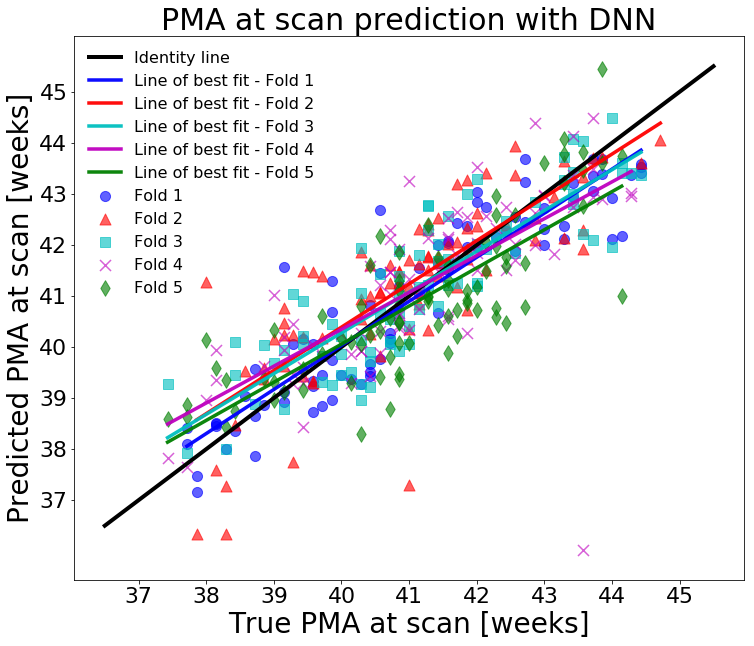

In [12]:
MARKERS = ['o', '^', 's', 'x', 'd']
COLOURS = ['b', 'r', 'c', 'm', 'g']

plt.figure(figsize = (12,10))

plt.plot([36.5, 45.5],[36.5, 45.5], label = 'Identity line', color = 'k', lw = 4)
for i in range(len(Predicted_Fold_Subjects)):
    
    True_PMA = Test_Fold_Subjects[i]
    Predicted_PMA = Predicted_Fold_Subjects[i]
  

    modelLR = LinearRegression()
    Model = modelLR.fit(np.array(True_PMA).reshape(-1, 1), np.array(Predicted_PMA).reshape(-1, 1))
    coeff = Model.coef_
    intercept = Model.intercept_
    xxx = np.linspace(min(True_PMA), max(True_PMA), 5)
    yyy = coeff*xxx + intercept


    if i == 0:
        plt.scatter(True_PMA, Predicted_PMA, label = 'Fold %s' %str(i+1), marker = MARKERS[i], color = COLOURS[i], alpha=.62, s = 102)
    elif i ==2:
        plt.scatter(True_PMA, Predicted_PMA, label = 'Fold %s' %str(i+1), marker = MARKERS[i], color = COLOURS[i], alpha=.62, s = 112)

    else:
        plt.scatter(True_PMA, Predicted_PMA, label = 'Fold %s' %str(i+1), marker = MARKERS[i], color = COLOURS[i], alpha=.62, s = 122)
    plt.plot(xxx, yyy, color = COLOURS[i], label = str('Line of best fit - ' + 'Fold ' +  str(i+1)), lw = 3.5, alpha = 0.95)
    plt.xticks([37, 38, 39, 40, 41, 42, 43, 44, 45], fontsize = 22)
    plt.yticks([37, 38, 39, 40, 41, 42, 43, 44, 45], fontsize = 22)
    plt.xlabel('True PMA at scan [weeks]', fontsize=28)
    plt.ylabel('Predicted PMA at scan [weeks]',fontsize=28)
    plt.title('PMA at scan prediction with DNN', fontsize=30)
    plt.legend(fontsize = 16, loc = 2, frameon = False)
    plt.savefig('DNN_PMA.png', dpi=250)
    

In [13]:
Performance_Scores(Test_Fold_Subjects, Predicted_Fold_Subjects)

For fold 1 --- MAE = 0.6227249471222611 --- Corr = 0.9179811965488637 --- p value = 1.1142536615178975e-34 --- MAD of prediction: 2.398853382042618 --- R2:  0.8386975094442307
For fold 2 --- MAE = 0.8014126645381664 --- Corr = 0.8066261494576634 --- p value = 2.0333407582517702e-20 --- MAD of prediction: 1.3420512622228598 --- R2:  0.5671065716009274
For fold 3 --- MAE = 0.6605925955659414 --- Corr = 0.8665164908149059 --- p value = 1.815809049872322e-26 --- MAD of prediction: 1.6981369409510163 --- R2:  0.7471831823688423
For fold 4 --- MAE = 0.736779925043653 --- Corr = 0.7285245162287017 --- p value = 5.906774540590824e-15 --- MAD of prediction: 1.7439252552103723 --- R2:  0.46148244047508524
For fold 5 --- MAE = 0.7769180373164146 --- Corr = 0.8068152393612715 --- p value = 3.339856297527988e-20 --- MAD of prediction: 1.2865591178329017 --- R2:  0.6177944020311026
For total scores, MAE = 0.7195078188586138 --- Corr = 0.8275680034158948 --- p value = 2.2912038663048476e-106 --- MAD 

# Random Forest Training

## Training

In [14]:
#We use same splits as the DNN training

#This is all using same methods and ideas as with the DNN training

RF_Correction_Parameters = []
RF_Normalization_Parameters = []
RF_PMA_Models = []
Corrected_Predictions_RF = []
Test_Output_5_Folds = []



for i in range(n_folds):

    Non_Normalized_Training_Input = X_Term[Train_Folds_Indexes[i]]
    Non_Normalized_Testing_Input = X_Term[Test_Folds_Indexes[i]]
    
    Min_Training_Input = np.min(Non_Normalized_Training_Input)
    Max_Training_Input = np.max(Non_Normalized_Training_Input)

    Normalization_Values_DNN.append([Min_Training_Input, Max_Training_Input]) #Saving normalization values
    
    Training_Input = Normalize_Vectors(Non_Normalized_Training_Input, Min_Training_Input, \
                              Max_Training_Input)
    
    Testing_Input = Normalize_Vectors(Non_Normalized_Testing_Input, Min_Training_Input, \
                              Max_Training_Input)

    Training_Output = PMA_Term[Train_Folds_Indexes[i]]
    Testing_Output = PMA_Term[Test_Folds_Indexes[i]]


    # Initializing tests to take model with good performance by testing on validation
    Max_Residual = 10 #max true - predicted
    Corr_Val = 0 # correlation between true and predicted
    MAE_Val = 10 # mean absolute error of true and predict
    
    while Max_Residual > 9 or Corr_Val < 0.7 or MAE_Val > 2.5:
        
        
        # Get 15% validation set out of training sample
        xtrain, xval, ytrain, yval = train_test_split(Training_Input, Training_Output, \
                                test_size = 0.15, random_state= random.randint(0,101)) 
        
        Local_Model_PMA_RF = None 
        Local_Model_PMA_RF = RandomForestRegressor(max_depth= 3401,max_features = 3503,
                        n_estimators= 45,
                        random_state=42)
        Local_Model_PMA_RF.fit(xtrain, ytrain)
        Validation_Preds = Local_Model_PMA_RF.predict(xval)
        Training_Preds = Local_Model_PMA_RF.predict(xtrain)
        
        MAE_Val = Get_Mean_Absolute_Error(Validation_Preds, yval)
        Corr_Val = scipy.stats.pearsonr(yval.flatten(), Validation_Preds.flatten())[0]
        Max_Residual = np.max(Validation_Preds-yval) 
        
        Both_Predictions = np.hstack((Training_Preds, Validation_Preds))
        Both_Ys = np.hstack((ytrain.flatten(), yval.flatten()))
        
        Local_Parameters = Get_Model_Bias(Both_Ys.reshape(-1, 1), Both_Predictions.reshape(-1, 1))
        
        
    #Exited while loop - trained model is a keeper!
    print('fold', i+1, 'successfully trained')
    
    #Compute prediction on test set
    Test_Predctions_RF = Local_Model_PMA_RF.predict(Testing_Input)
    Test_Predctions_RF_Bias_Corrected = Test_Predctions_RF + Test_Predctions_RF*Local_Parameters[0] \
                        + Local_Parameters[1]
    
    
    # Save DNN model, bias parameters and predictions 
    RF_PMA_Models.append(Local_Model_PMA_RF)
    RF_Correction_Parameters.append(Local_Parameters)
    Corrected_Predictions_RF.append(Test_Predctions_RF_Bias_Corrected[0])
    Test_Output_5_Folds.append(Testing_Output)
    
    
    #Compute scores on test set
    Mean_Absolute_Error_Test = Get_Mean_Absolute_Error(Testing_Output, Test_Predctions_RF_Bias_Corrected[0])
    Correlation_Test = scipy.stats.pearsonr(np.array(Testing_Output).flatten(), np.array(Test_Predctions_RF_Bias_Corrected[0]).flatten())
    
    
print('Training successful done on all folds')   

fold 1 successfully trained
fold 2 successfully trained
fold 3 successfully trained
fold 4 successfully trained
fold 5 successfully trained
Training successful done on all folds


## Saving models and predictions

In [15]:
#Save models locally
for i in range(5):
    loc_model = RF_PMA_Models[i]
    with open(str('PMA_RF_Model' + str(i) + '.pkl'), 'wb') as f:  
        pickle.dump(loc_model, f) 
    
# Save predictions 
with open('Corrected_Predictions_RF_5_Folds_PMA.pkl', 'wb') as f:  
    pickle.dump(Corrected_Predictions_RF, f) 
    
# Save Bias parameters
with open('Bias_Parameters_PMA_RF.pkl', 'wb') as f:  
    pickle.dump(RF_Correction_Parameters, f) 

# Save Normalization parameters
with open('Normalization_Parameters_PMA_RF.pkl', 'wb') as f:  
    pickle.dump(RF_Normalization_Parameters, f)

# RF Visualization

In [16]:
# ## Loading data

with open('PMA_Files/RF/Test_Output_5_Folds_PMA.pkl', 'rb') as f:  
    Test_Fold_Subjects_RF = pickle.load(f)
    
with open('PMA_Files/RF/Corrected_Predictions_RF_5_Folds_PMA.pkl', 'rb') as f:  
    Predicted_Fold_Subjects_RF = pickle.load(f)

    

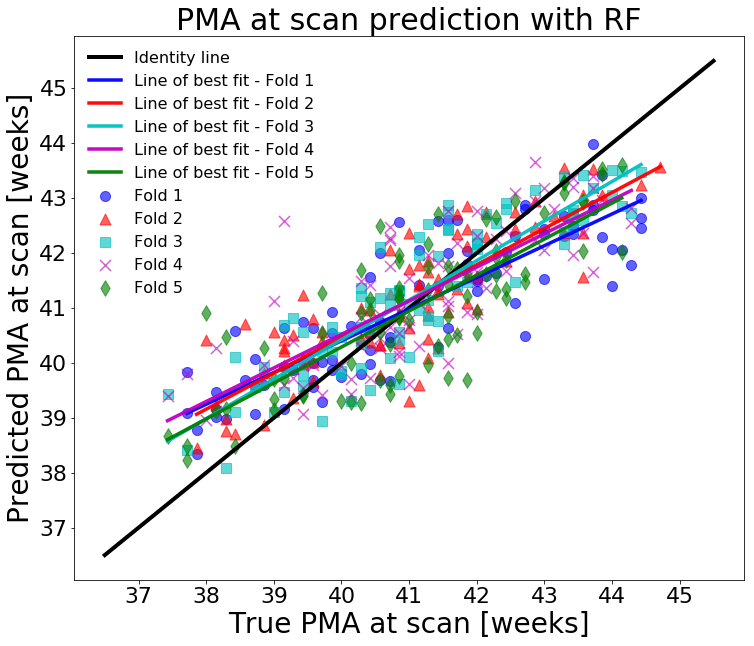

In [17]:
MARKERS = ['o', '^', 's', 'x', 'd']
COLOURS = ['b', 'r', 'c', 'm', 'g']

plt.figure(figsize = (12,10))

plt.plot([36.5, 45.5],[36.5, 45.5], label = 'Identity line', color = 'k', lw = 4)
for i in range(len(Predicted_Fold_Subjects)):
    
    True_PMA = Test_Fold_Subjects_RF[i]
    Predicted_PMA = Predicted_Fold_Subjects_RF[i]
  

    modelLR = LinearRegression()
    Model = modelLR.fit(np.array(True_PMA).reshape(-1, 1), np.array(Predicted_PMA).reshape(-1, 1))
    coeff = Model.coef_
    intercept = Model.intercept_
    xxx = np.linspace(min(True_PMA), max(True_PMA), 5)
    yyy = coeff*xxx + intercept


    if i == 0:
        plt.scatter(True_PMA, Predicted_PMA, label = 'Fold %s' %str(i+1), marker = MARKERS[i], color = COLOURS[i], alpha=.62, s = 102)
    elif i ==2:
        plt.scatter(True_PMA, Predicted_PMA, label = 'Fold %s' %str(i+1), marker = MARKERS[i], color = COLOURS[i], alpha=.62, s = 112)

    else:
        plt.scatter(True_PMA, Predicted_PMA, label = 'Fold %s' %str(i+1), marker = MARKERS[i], color = COLOURS[i], alpha=.62, s = 122)
    plt.plot(xxx, yyy, color = COLOURS[i], label = str('Line of best fit - ' + 'Fold ' +  str(i+1)), lw = 3.5, alpha = 0.95)
    plt.xticks([37, 38, 39, 40, 41, 42, 43, 44, 45], fontsize = 22)
    plt.yticks([37, 38, 39, 40, 41, 42, 43, 44, 45], fontsize = 22)
    plt.xlabel('True PMA at scan [weeks]', fontsize=28)
    plt.ylabel('Predicted PMA at scan [weeks]',fontsize=28)
    plt.title('PMA at scan prediction with RF', fontsize=30)
    plt.legend(fontsize = 16, loc = 2, frameon = False)
    plt.savefig('RF_PMA.png', dpi=250)
    

In [18]:
Performance_Scores(Test_Fold_Subjects_RF, Predicted_Fold_Subjects_RF)

For fold 1 --- MAE = 0.857038997362308 --- Corr = 0.857061390697528 --- p value = 2.4652236080570446e-25 --- MAD of prediction: 1.7103710741600076 --- R2:  0.7003363272500462
For fold 2 --- MAE = 0.6838186448248685 --- Corr = 0.8455671667878049 --- p value = 4.6150085966591076e-24 --- MAD of prediction: 1.1630519970000004 --- R2:  0.7018357963988562
For fold 3 --- MAE = 0.6768953440206085 --- Corr = 0.875523568166403 --- p value = 1.2487519781867589e-27 --- MAD of prediction: 1.7308850018978401 --- R2:  0.7603961140397983
For fold 4 --- MAE = 0.7535300651822079 --- Corr = 0.7887234718104021 --- p value = 8.526757257685982e-19 --- MAD of prediction: 1.6639240097433003 --- R2:  0.6198081416241694
For fold 5 --- MAE = 0.7663219865146584 --- Corr = 0.8002304000697272 --- p value = 1.12844085375607e-19 --- MAD of prediction: 1.2640459633681873 --- R2:  0.636879940563289
For total scores, MAE = 0.7474616534265403 --- Corr = 0.8313059941402492 --- p value = 3.655160381210862e-108 --- MAD of p